In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
#Loading Training Data
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [3]:
#Loading Test Data
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


* Computing Basic Statistics For Numerical Data (Mean, Median, Standard Deviation, Minimum, Maximum, and Quartiles)
* Frequency Distribution of each category for catagorical data

In [4]:
#Numerical Data
stats = train_data.describe()
print(stats)

       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200  


In [5]:
#Catagorical Data, We didn't include Name and Cabin as they're of little to no use to us in the data summarization phase.

print(train_data['Sex'].value_counts())
print(train_data['Embarked'].value_counts())

Sex
male      577
female    314
Name: count, dtype: int64
Embarked
S    644
C    168
Q     77
Name: count, dtype: int64


Task 2: Analyze the percentage of missing values in each feature and decide on an appropriate strategy for imputation

In [6]:
#First we check for missing values in each column
print(train_data.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [7]:
#We drop the rows where embarked is null since they're only 2 rows out of 891.
train_data.dropna(subset=['Embarked'], inplace= True)
#We apply the same changes to the test data
test_data.dropna(subset=['Embarked'], inplace=True)
#We drop the Cabin column, 687/791 missing values.
train_data.drop(columns =['Cabin'], inplace = True)
#We apply the same changes to the test data

test_data.drop(columns =['Cabin'], inplace = True)

#We use the Median because we have outliers 
train_data['Age'] = train_data['Age'].fillna(train_data['Age'].median())
test_data['Age'] = test_data['Age'].fillna(test_data['Age'].median())


In [8]:
#Check after imputing missing values
print(train_data.isnull().sum())

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64


In [9]:
# we turn the catagorical features into numerical data to be easier to deal with
encoder = LabelEncoder()

num_data = train_data.copy()
num_data_test = test_data.copy()

encoder.fit(num_data['Sex'])
num_data['Sex_encoded'] = encoder.transform(num_data['Sex'])

encoder.fit(num_data_test['Sex'])
num_data_test['Sex_encoded'] = encoder.transform(num_data_test['Sex'])


encoder.fit(num_data['Embarked'])
num_data['Emb_encoded'] = encoder.transform(num_data['Embarked'])

encoder.fit(num_data_test['Embarked'])
num_data_test['Emb_encoded'] = encoder.transform(num_data_test['Embarked'])

In [10]:
#we create a new dataframe with only the data that could affect the survival rate
num_data = num_data.drop(columns =['Name','Sex','Ticket','Embarked'])

num_data.head()

num_data_test = num_data_test.drop(columns =['Name','Sex','Ticket','Embarked'])

num_data_test.head()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Sex_encoded,Emb_encoded
0,892,3,34.5,0,0,7.8292,1,1
1,893,3,47.0,1,0,7.0000,0,2
2,894,2,62.0,0,0,9.6875,1,1
3,895,3,27.0,0,0,8.6625,1,2
4,896,3,22.0,1,1,12.2875,0,2



Outliers:


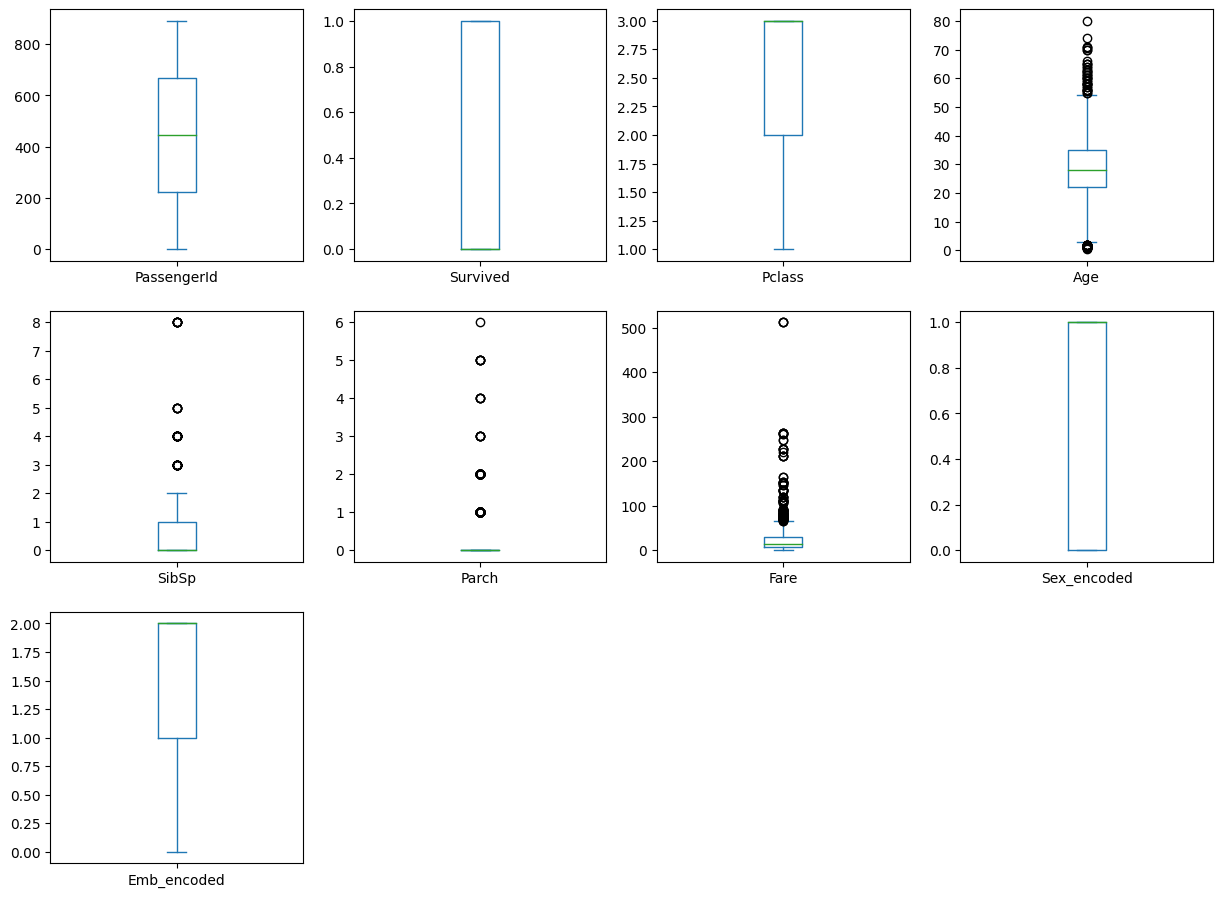

In [11]:
#4 Outliers Detection:
print("\nOutliers:")
num_data.plot(kind='box', subplots=True, layout=(4, 4), figsize=(15, 15))
plt.show()

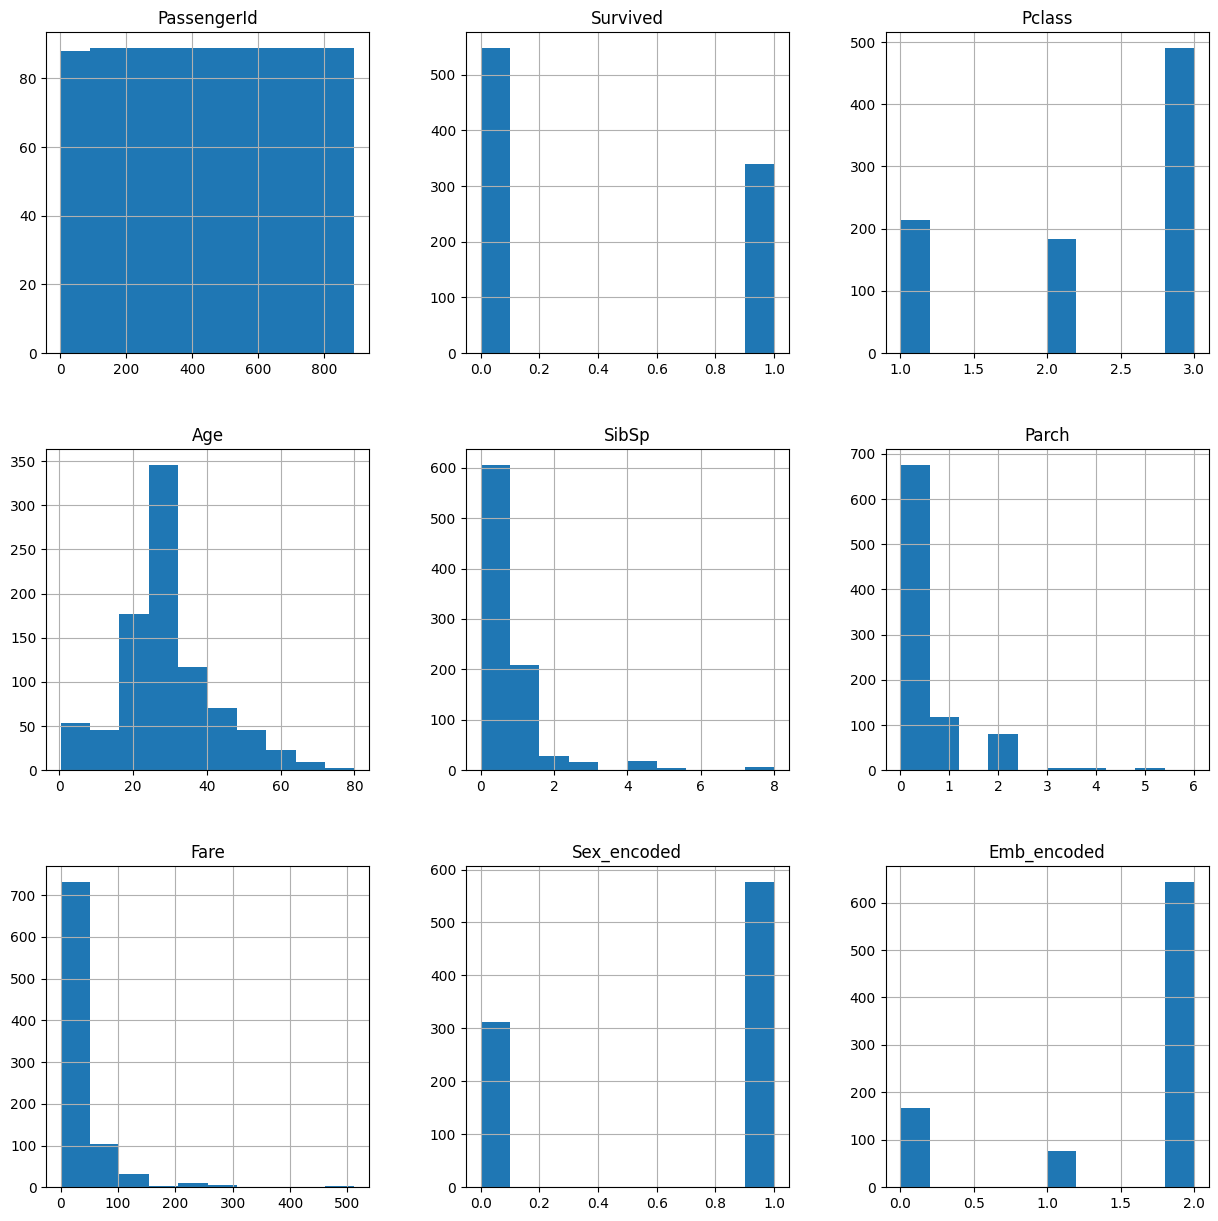

In [12]:
#5 Data Visualization:
num_data.hist(figsize=(15, 15))
plt.show()

In [13]:
#6 Feature Distribution:
skewness = num_data.skew()
print(skewness)

PassengerId    0.000000
Survived       0.484568
Pclass        -0.636998
Age            0.508010
SibSp          3.691058
Parch          2.745160
Fare           4.801440
Sex_encoded   -0.625625
Emb_encoded   -1.261367
dtype: float64


No need to transformation / normalization

In [14]:
#7 Feature Correlation:
correlation = num_data.corr()
print(correlation)

             PassengerId  Survived    Pclass       Age     SibSp     Parch  \
PassengerId     1.000000 -0.005028 -0.035330  0.031319 -0.057686 -0.001657   
Survived       -0.005028  1.000000 -0.335549 -0.069822 -0.034040  0.083151   
Pclass         -0.035330 -0.335549  1.000000 -0.336512  0.081656  0.016824   
Age             0.031319 -0.069822 -0.336512  1.000000 -0.232543 -0.171485   
SibSp          -0.057686 -0.034040  0.081656 -0.232543  1.000000  0.414542   
Parch          -0.001657  0.083151  0.016824 -0.171485  0.414542  1.000000   
Fare            0.012703  0.255290 -0.548193  0.093707  0.160887  0.217532   
Sex_encoded     0.043136 -0.541585  0.127741  0.086506 -0.116348 -0.247508   
Emb_encoded     0.013166 -0.169718  0.164681 -0.020933  0.068900  0.040449   

                 Fare  Sex_encoded  Emb_encoded  
PassengerId  0.012703     0.043136     0.013166  
Survived     0.255290    -0.541585    -0.169718  
Pclass      -0.548193     0.127741     0.164681  
Age          0.0937

In [15]:
#8 Feature Engineering:
new_column = 'class_Fare'

train_data[new_column] = train_data['Pclass'].astype(str) + '_' + train_data['Fare'].astype(str)
train_data = train_data.drop(columns =['Pclass','Fare'])
#apply the same to test
test_data[new_column] = test_data['Pclass'].astype(str) + '_' + test_data['Fare'].astype(str)
test_data = test_data.drop(columns =['Pclass','Fare'])

In [16]:
# 9 Data Separation and Model Selection:
# Splitting the training data into training and validation sets
X = num_data.drop(columns=['Survived'])
y = num_data['Survived']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
#Model #1, Logistic Regression
model = LogisticRegression(max_iter=200) #tried 100, showed me an error asking to increase it since the data isn't scaled.
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
train_accuracy = accuracy_score(y_train, model.predict(X_train))

print("\nTrain set accuracy:", train_accuracy)
print(f"Accuracy: {accuracy}")


Train set accuracy: 0.7974683544303798
Accuracy: 0.7752808988764045


In [18]:
#Model #2, Decision Tree
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(criterion="entropy", random_state = 100, max_depth = 3)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
train_accuracy = accuracy_score(y_train, model.predict(X_train))

print("\nTrain set accuracy:", train_accuracy)
print(f"Accuracy: {accuracy}")


Train set accuracy: 0.8227848101265823
Accuracy: 0.8202247191011236


In [19]:
#Model #3, KNN
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors = 15) 
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
train_accuracy = accuracy_score(y_train, model.predict(X_train))

print("\nTrain set accuracy:", train_accuracy)
print(f"Accuracy: {accuracy}")


Train set accuracy: 0.6891701828410689
Accuracy: 0.6685393258426966


As we can see from the tests above, Decision tree had the highest accuracy

In [20]:
#Had an issue here where 1 value in fare was null so I had to drop it
print(num_data_test.isnull().sum())
num_data_test.dropna(subset=['Fare'], inplace=True)
print(num_data_test.isnull().sum())

PassengerId    0
Pclass         0
Age            0
SibSp          0
Parch          0
Fare           1
Sex_encoded    0
Emb_encoded    0
dtype: int64
PassengerId    0
Pclass         0
Age            0
SibSp          0
Parch          0
Fare           0
Sex_encoded    0
Emb_encoded    0
dtype: int64


In [21]:
model = DecisionTreeClassifier(criterion="entropy", random_state = 100, max_depth = 3)
model.fit(X, y)
test_predictions = model.predict(num_data_test)
output = pd.DataFrame({'PassengerId': num_data_test['PassengerId'], 'Survived': test_predictions})
print(output.head) 

<bound method NDFrame.head of      PassengerId  Survived
0            892         0
1            893         1
2            894         0
3            895         0
4            896         1
..           ...       ...
413         1305         0
414         1306         1
415         1307         0
416         1308         0
417         1309         0

[417 rows x 2 columns]>
